In [3]:
import cv2
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pytesseract
import pyzbar.pyzbar as pyzbar

print(cv2.__version__)

4.5.1


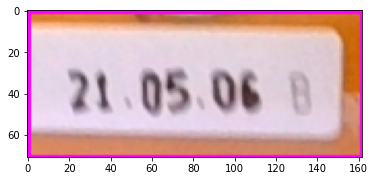

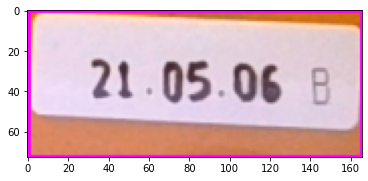

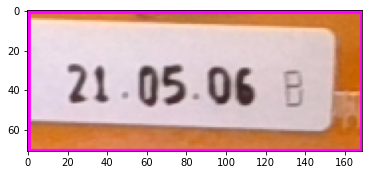

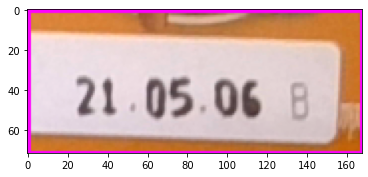

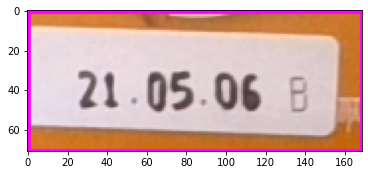

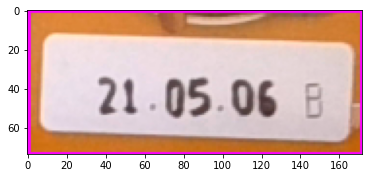

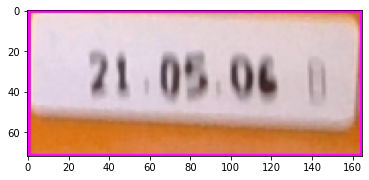

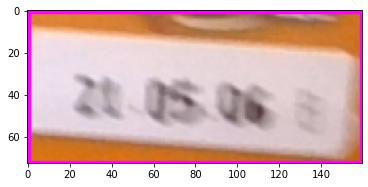

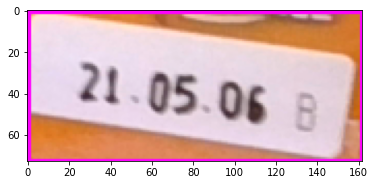

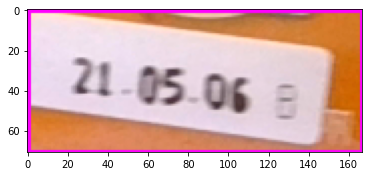

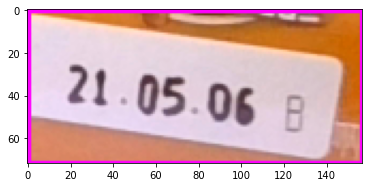

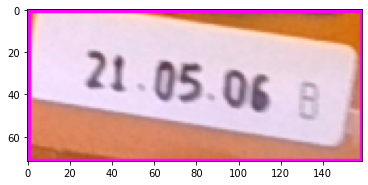

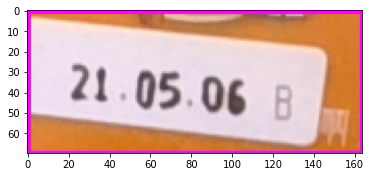

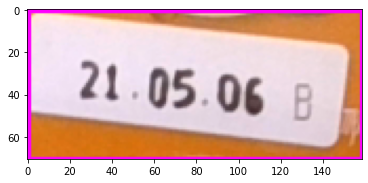

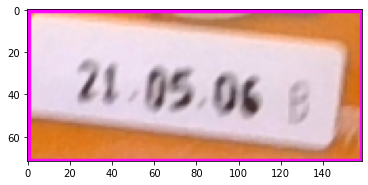

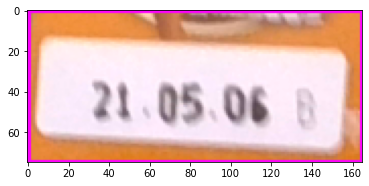

KeyboardInterrupt: 

In [4]:
cap = cv2.VideoCapture(0)
whT = 320

confThreshold = 0.5
nmsThreshold = 0.3

EDrac = [0,0,0,0,0]
x,y,w,h = 0,0,0,0
#EDBC= np.array()

classesFile = 'obj.names'   #내가 가지는 클래스 이름이 들어가있는 파일
classNames = []

with open(classesFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')   #Expiration date 하나밖에 없어서 이거 하나
    
    
#print(classNames)
#print(len(classNames))

modelConfiguration= 'yolov3_ED.cfg' #모델 구조
modelWeights= 'yolov3_best.weights' #가중치

net = cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights) #다크넷 실행 모델구조랑 가중치 들고오겠다.
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) #
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

#유통기한을 찾아서 네모 쳐주는 함수    
def findObjects(outputs,img):
    hT, wT, cT, = img.shape
    bbox= []
    classIds = []
    confs = []
    
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId= np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                w,h = int(det[2]*wT), int(det[3]*hT)
                x,y = int((det[0]*wT)-w/2), int((det[1]*hT)-h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices = cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    #네모치는 곳
    for i in indices:
        i = i[0]
        box = bbox[i]
        x,y,w,h = box[0],box[1],box[2],box[3]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.putText(img,f'{classNames[classIds[i]].upper()} {int(confs[i]*100)}%', (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            
        #print(classNames[classIds[i]].upper())
        if indices == [[0]]:
            EDrac[0] = 1
            EDrac[1] = x
            EDrac[2] = y
            EDrac[3] = w
            EDrac[4] = h
        else:
            EDrac[0]= 0
        
        if EDrac[0] == 1:
            ED_pic = img[EDrac[2]:EDrac[2]+EDrac[4], EDrac[1]:EDrac[1]+EDrac[3]]
            plt.imshow(ED_pic)


#---------------------------------------------------------------

while True:
    success, img = cap.read()

    blob = cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
    net.setInput(blob)

    layerNames = net.getLayerNames()
   # print(layerNames)
    outputNames = [layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]
    #print(outputNames) 
   # print(net.getUnconnectedOutLayers())

    outputs = net.forward(outputNames)

    findObjects(outputs,img)

    
    plt.show()
  #  print(EDrac)       

    cv2.imshow('Img',img)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    elif key == ord('s'):
        i += 1
        cv2.imwrite('c_%03d.jpg' % i, img)
        
